# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*


![](https://drive.google.com/uc?export=view&id=1Aze8Xe_ZZpV22IwFNUH09T2howHmF1AK)

[Image Credit: slides from Ben Mabey](https://speakerdeck.com/bmabey/visualizing-topic-models)

Apply Topic Modeling to Analyze a corpus of Amazon reviews

- Load in the Amazon Review dataset
- Clean the dataset
- Vectorize the dataset
- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end

In [ ]:
#!pip install pyLDAvis==3.3.1

In [ ]:
#!pip install pandarallel==1.4.8

In [ ]:
# !python -m spacy download en_core_web_md

## Restart runtime!

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy
spacy.util.fix_random_seed(0)

import pyLDAvis
import pyLDAvis.gensim_models

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from pandarallel import pandarallel

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


----
### Load the Amazon Review corpus
This dataset is located in the Sprint 1 Module 1 `/data` directory.

If the provided relative path doesn't work for you, then you'll have to provide the file path so pandas can read in the file.

In [2]:
# A "brute force" way to get the Amazon reviews dataset; just clone the Sprint 1 repo!
# Overkill, but it does the job!
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git

Cloning into 'DS-Unit-4-Sprint-1-NLP'...
remote: Enumerating objects: 1742, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 1742 (delta 115), reused 157 (delta 88), pack-reused 1532
Receiving objects: 100% (1742/1742), 60.07 MiB | 18.08 MiB/s, done.
Resolving deltas: 100% (284/284), done.


In [3]:
!unzip '/content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip'

Archive:  /content/DS-Unit-4-Sprint-1-NLP/module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv.zip
  inflating: Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv  


In [4]:
data_path = "/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
df = pd.read_csv(data_path)

In [5]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."


----

### Clean data

- Create a function called `clean_data` that uses regex expressions to clean your data in preparation for the vectorizer.

- Save the clean text data to a column in your dataframe named `clean_text`

- Feel free to re-use old code that you have written in previous modules  

In [6]:
df.shape

(28332, 24)

In [7]:
df['reviews.text'][8505]

'Have had zero issues with longevity or voltage. As good as the major brand batteries'

In [14]:
import re
import string

def clean_data(text):
  """
  Cleans data to remove unwanted characters and punctuation.
  """
 # YOUR CODE HERE

  # Remove URLS
  text = re.sub(r'http\S+|www\S+|https|S+', '', text, flags=re.MULTILINE)
  # Remove user @ references and '#' from text
  text = re.sub(r'\@\w+|\#','', text)
  # Remove punctuations
  text = text.translate(str.maketrans('','', string.punctuation))
  # Convert text to lowercase
  text = text.lower()
  return text

In [15]:
# create a clean_text column by applying  clean_data to your text
df['clean_text'] = df['reviews.text'].apply(clean_data)

In [16]:
alphebetical_chars = ["ABCDEFGHIJKLMNOP"]
# check if any of these alphabetical chars exist in your clean chars
assert df.clean_text.isin(alphebetical_chars).sum() == 0, "Did you case normalize your text inside of your clean_data function?"

------

## Determine number of topics

We are going to run an experiment to determine how many topics exists within the `primaryCategories` of `Electronics`. This is the largest primary category containing nearly 14K documents, so we should have plenty of data.

Just as we did in the guided project, we'll be running a gridseach over the number of topics and scoring each model using the Coherence metric to determine which number of topics we should use.


In [19]:
# create a mask for docs that are in the Electronics primaryCategories - save result to `electronics_mask`
electronics_mask = df.primaryCategories.isin(["Electronics"])

# use mask to select all the documents in the Electronics primaryCategories - save result to `df_electronics`
df_electronics = df[electronics_mask]

In [24]:
df_electronics.head(3)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,clean_text
8343,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,Great case to keep everything in its place! My...,Excellent product,qs341_5,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,great case to keep everything in its place my ...
8344,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,http://www.amazon.co.uk/gp/product-reviews/B00...,After discarding and getting rid of broken cd ...,It was a much needed storage,Diablita,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,after discarding and getting rid of broken cd ...
8345,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,"A few dollars more, but I am boycotting amazon",it was worth it,coldbloodblazing,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...,a few dollars more but i am boycotting amazon


------
### Tokenize your documents

Remember that you'll need to use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class from the Gensim library. So definitely check out the docs to learn more about this tool. There is an example on how to do this in the guided project.

But before we can use the [**corpora**](https://radimrehurek.com/gensim/corpora/dictionary.html) class, we must first tokenize our articles.



In [25]:
import multiprocessing
from gensim import corpora

# identify how many processors your machine has - save the result to `n_processors`
n_processors = multiprocessing.cpu_count()

# subtract 1 from n_processors - save the result to `nb_workers`
nb_workers = n_processors - 1

# initialize just like we did in the guided project


In [26]:
# load in the spaCy language model
nlp = spacy.load("en_core_web_md")

In [27]:
%%time
# create our tokens in the form of lemmas
df_electronics['lemmas'] = df_electronics['clean_text'].apply(lambda x: [token.lemma_ for token in nlp(x) if (token.is_stop != True) and (token.is_punct != True)])

CPU times: user 2min 39s, sys: 515 ms, total: 2min 40s
Wall time: 2min 47s


### Use the corpora class to prep your data for LDA

You'll need to create the same `id2word` and `corpus` objects that we created in the guided projects. So be sure to reference the guided project notebook if you need to.

In [29]:
# Create lemma dictionary using Dictionary - save result to `id2word` --id2word is a Gensim dictionary that maps every word to an id.
id2word =corpora.Dictionary(df_electronics['lemmas'])

'''
The corpora.Dictionary function creates a mapping with an ID for each word. The next step is to use the doc2bow method for each document
to convert words to their respective IDs and count the frequency of each word. This will create the corpus, a list of vectors equal to the
number of documents, where each vector has a series of tuples. Each tuple refers to an ID from the dictionary and its frequency in the document.
Here is how you can do it:
'''
# Create Term Document Frequency list - save result to `corpus`
corpus = [id2word.doc2bow(text) for text in df_electronics['lemmas']] # corpus is a list of vectors where each vector represents a document. In each vector, each element is a tuple of a word id and the frequency of that word in the document.


## Gridsearch the number of topics

Just as we did in the guided project, we're going to run a `for` loop over a range of possible number of topics and then plot the `coherence_values` to determine which number of topics leads to the most sensible grouping of documents.

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        chunksize=100,
                                                        passes=10,
                                                        random_state=1234,
                                                        per_word_topics=True,
                                                        workers=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_electronics['lemmas'], start=2, limit=16, step=2)

CPU times: user 3min 45s, sys: 12.5 s, total: 3min 58s
Wall time: 6min 51s


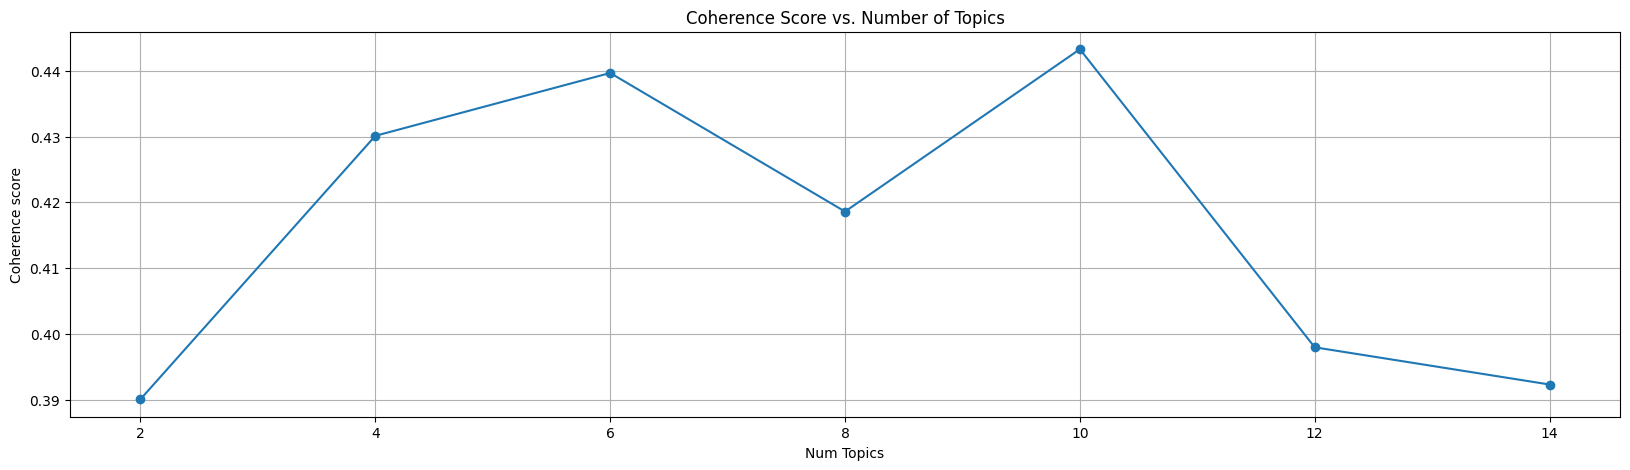

In [32]:
start=2; limit=16;  step=2;
x = range(start, limit, step)

plt.figure(figsize=(20,5))
plt.grid()
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(x)
plt.plot(x, coherence_values, "-o")

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

plt.show();

In [38]:
# use np.argmax() to get index of largest coherence value from coherence_values - save result to `max_cohereance_val_index`

# use `max_coherence_val_index` to index model_list for the corresponding model - save result to `lda_trained_model`

max_coherence_val_index = np.argmax(coherence_values)
print(f'Model number {max_coherence_val_index} has the highest coherence value')

lda_trained_model = model_list[max_coherence_val_index]

# YOUR CODE HERE

Model number 4 has the highest coherence value


In [37]:
lda_trained_model.show_topics()

[(0,
  '0.084*"read" + 0.080*"book" + 0.042*"download" + 0.039*"use" + 0.028*"easy" + 0.027*"internet" + 0.022*"watch" + 0.020*"app" + 0.017*"learn" + 0.017*"want"'),
 (1,
  '0.051*"buy" + 0.023*"purchase" + 0.020*"happy" + 0.019*" " + 0.019*"good" + 0.017*"not" + 0.017*"grandson" + 0.016*"replace" + 0.013*"2" + 0.013*"time"'),
 (2,
  '0.068*"amazon" + 0.063*"app" + 0.037*"not" + 0.033*"play" + 0.023*"google" + 0.022*"prime" + 0.022*"game" + 0.020*"store" + 0.017*"like" + 0.014*"thing"'),
 (3,
  '0.154*"kindle" + 0.091*"fire" + 0.046*"new" + 0.036*"old" + 0.029*"well" + 0.024*"love" + 0.022*"7" + 0.022*"email" + 0.019*"upgrade" + 0.018*"light"'),
 (4,
  '0.087*"love" + 0.054*"buy" + 0.043*"great" + 0.042*"gift" + 0.038*"tablet" + 0.028*"christmas" + 0.026*"purchase" + 0.026*"fire" + 0.022*"hd" + 0.019*"get"'),
 (5,
  '0.102*"tablet" + 0.086*"good" + 0.069*"price" + 0.053*"great" + 0.032*"ipad" + 0.027*"product" + 0.027*"not" + 0.020*"need" + 0.020*"work" + 0.017*"amazon"'),
 (6,
  '0.0

## Use pyLDAvis to visualize your topics

Take a look at the topic bubbles and bar chart for the terms on the right hand side.  

- Describe the topic bubbles.
- Do they overlap or not?
- What does it mean when they overlap?
- What does it mean when they don't overlap?
- Are the terms in each topic distinct from the topics in the other topic bubbles?


In [ ]:
#!pip install ipywidgets

In [36]:
# plot your topics here -- using pyLDAvis
# YOUR CODE HERE
import pyLDAvis.gensim_models

# Prepare the visualization
vis = pyLDAvis.gensim_models.prepare(lda_trained_model, corpus, id2word)

# Display the visualization
pyLDAvis.display(vis)

Describe the topic bubbles. Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent that topic is.

Do they overlap or not? If the bubbles overlap, it means that those topics share a lot of terms. If they don't overlap, it means that the topics are distinct.

What does it mean when they overlap? Overlapping topics share a lot of terms. This might indicate that these topics are not very well differentiated from each other.

What does it mean when they don't overlap? Non-overlapping topics are distinct, meaning they don't share many terms.

Are the terms in each topic distinct from the topics in the other topic bubbles? This can be observed from the right-hand side bar chart. If the terms (represented by the bars) in each topic are different from the terms in other topics, then the topics are well differentiated. If many terms are shared among topics, it might indicate that the topics are not very distinct.

## Create a Topic id/name dictionary

When populating your topic id/name dictionary, use the index ordering as shown in the viz tool.

We'll use a function to map the the viz tool index ordering with the train LDA model ordering.

In [54]:
# create a dictionary
# keys - use topic ids from pyLDAvis visualization
# values - topic names that you create
# save dictionary to `vis_topic_name_dict`

vis_topic_name_dict = {1 : 'Kid/Tablet/Game', 2 : 'Good Purchase',
                       3 : 'Tablet', 4 : 'Amazon App',
                       5 : 'Family Gift', 6 : 'Tablet', 7: 'E-Reader',
                       8: 'Kindle Fire', 9: 'Battery Issues', 10: 'Alexa'}

In [55]:
def get_topic_id_lookup_dict(vis, vis_topic_name_dict):
    """
    Both the starting index and the ordering of topic ids bewteen the trained LDA model
    and the viz tool are different. So we need to create a look up dictionary that maps
    the correct association between topic ids from both sources.
    """
    # value is order of topic ids accoridng to pyLDAvis tool
    # key is order of topic ids according to lda model
    model_vis_tool_topic_id_lookup = vis.topic_coordinates.topics.to_dict()

    # invert dictionary so that
    # key is order of topic ids accoridng to pyLDAvis tool
    # value is order of topic ids according to lda model
    topic_id_lookup =  {v:k for k, v in model_vis_tool_topic_id_lookup.items()}

    return {v:vis_topic_name_dict[k]  for k, v in topic_id_lookup.items()}

Create a topic id/name look up dict
that is aligned with the index ordering of the trained LDA model

In [56]:
topic_name_dict = get_topic_id_lookup_dict(vis, vis_topic_name_dict)

In [57]:
topic_name_dict

{9: 'Kid/Tablet/Game',
 1: 'Good Purchase',
 5: 'Tablet',
 2: 'Amazon App',
 4: 'Family Gift',
 8: 'Tablet',
 0: 'E-Reader',
 3: 'Kindle Fire',
 7: 'Battery Issues',
 6: 'Alexa'}

## Use the LDA Model to Assign Each Document a Topic Name

Now that we have a topic id/name look up dict that is aligned with the index ordering of the trained LDA model, we can move forward to giving each topic a topic name.

The function below has been given to you. However, you highly encouraged to read through it and make sure that you understand what it is doing each step of the way. In fact, a good way to do this is to copy and paste the code inside of the function into a new cell, comment out all the lines of code and line by line, uncomment the code and see the output.

In [58]:
def get_topic_ids_for_docs(lda_model, corpus):

    """
    Passes a Bag-of-Words vector into a trained LDA model in order to get the topic id of that document.

    Parameters
    ----------
    lda_model: Gensim object
        Must be a trained model

    corpus: nested lists of tuples,
        i.e. [[(),(), ..., ()], [(),(), ..., ()], ..., [(),(), ..., ()]]

    Returns
    -------
    topic_id_list: list
        Contains topic ids for all document vectors in corpus
    """

    # store topic ids for each document
    doc_topic_ids = []

    # iterature through the bow vectors for each doc
    for doc_bow in corpus:

        # store the topic ids for the doc
        topic_ids = []
        # store the topic probabilities for the doc
        topic_probs = []

        # list of tuples
        # each tuple has a topic id and the prob that the doc belongs to that topic
        topic_id_prob_tuples = lda_trained_model.get_document_topics(doc_bow)

        # iterate through the topic id/prob pairs
        for topic_id_prob in topic_id_prob_tuples:

            # index for topic id
            topic_id = topic_id_prob[0]
            # index for prob that doc belongs that the corresponding topic
            topic_prob = topic_id_prob[1]

            # store all topic ids for doc
            topic_ids.append(topic_id)
            # store all topic probs for doc
            topic_probs.append(topic_prob)

        # get the index for the topic that had the highest probability, for the current document
        max_topic_prob_ind = np.argmax(topic_probs)
        # get the corresponding topic id
        max_prob_topic_id = topic_ids[max_topic_prob_ind]
        # store the most probable topic id for the current document
        doc_topic_ids.append(max_prob_topic_id)

    return doc_topic_ids

In [59]:
# use get_topic_ids_for_docs to get the topic id for each doc in the corpus - save result to `doc_topic_ids`
doc_topic_ids = get_topic_ids_for_docs(lda_trained_model, corpus)

# create a new feature in df_electronics called topic_id using `doc_topic_ids`
df_electronics['topic_id'] = doc_topic_ids

# iterate through topic_id and use the lookup dict `topic_name_dict` to assign each document a topic name
# save results to a new feature in df_electronics called `new_topic_name`
df_electronics['new_topic_name'] = df_electronics['topic_id'].apply(lambda id: topic_name_dict[id])

## Congratulations! You have created new topic names for your documents.

In [60]:
cols = ["reviews.text", "new_topic_name", "topic_id"]
df_electronics[cols].head(15)

,reviews.text,new_topic_name,topic_id
8343,Great case to keep everything in its place! My...,Good Purchase,1
8344,After discarding and getting rid of broken cd ...,Battery Issues,7
8345,"A few dollars more, but I am boycotting amazon",Battery Issues,7
8346,My initial impression of this was very good. T...,Alexa,6
8347,Pros: Standard Echo. Cons: Older generation Ec...,Kid/Tablet/Game,9
8348,"Pros: Got it for under 50, much impressive sou...",Kid/Tablet/Game,9
8349,Pros: I love the Alexa series so when this one...,Good Purchase,1
8350,"ASIDE FROM THE FACT THAT THE SCREEN IS SMALL, ...",Tablet,8
8351,"I wasn't sure I even wanted this item, but cau...",Tablet,5
8352,Pros: Works good like Alexia Cons: setting it ...,Kid/Tablet/Game,9


-----
# Stretch Goals -- see if you can create a model to classify the reviews into the latent topics you've discovered!


- Treat `topic_id` as the `y` (target) vector and train a supervised learning model to predict the topic of each document
- Report your results on the Slack channel!

## Topic Modeling References



- [Topic Modeling with Gensim](https://www.tutorialspoint.com/gensim/gensim_topic_modeling.htm) -- Brief Tutorial

- [Gensim documentation](https://radimrehurek.com/gensim/index.html) -- look up gensim commands

- [`pyLDAvis` documentation](https://pyldavis.readthedocs.io/en/latest/readme.html) -- package for visualizing LDA models

- [Visualizing Topic Models](https://speakerdeck.com/bmabey/visualizing-topic-models) -- slides from Ben Mabey

- [Exploring the Space of Topic Coherence Measures](https://dl.acm.org/doi/10.1145/2684822.2685324) -- Study of Topic Coherence measures

- [Exploring Topic Coherence over many models and many topics](https://www.researchgate.net/publication/232242203_Exploring_Topic_Coherence_over_many_models_and_many_topics) -- Study of automated topic coherence measures